In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

In [9]:
publishedAt = []
title = []
viewCount = []
for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])

In [10]:
dict = {}
dict["publishedAt"] = publishedAt
dict["title"] = title
dict["viewCount"] = viewCount

In [11]:
import pandas as pd
df = pd.DataFrame.from_dict(dict)

In [12]:
df['viewCount'] = df['viewCount'].astype(int)

In [13]:
df.head()

,publishedAt,title,viewCount
0,2021-04-08T08:00:09Z,에이치엘비 CAR-T 상업화 최소 3년이상 앞당길 수 있다!! CAR-T세포가 활성...,3970
1,2021-04-08T01:34:11Z,에이치엘비 주주 오세훈 서울시장 당선!!,4407
2,2021-04-07T21:00:15Z,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,6848
3,2021-04-07T08:15:01Z,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7507
4,2021-04-07T03:00:11Z,에이치엘비가 뛰어든 CAR-T치료제의 부작용은 노바티스와 길리어드사이언스에서도 보이...,3161


In [33]:
len(df)

2591

# 제목에 '에이치엘비제약'이 있다면 Drop하기
같은 그룹이지만 분석의 일관성을 위해 에이치엘비제약을 빼고 순수한 에이치엘비만 다룬다.

In [18]:
df_1 = df.copy()

In [19]:
df_1['에이치엘비제약'] = df_1['title'].str.contains('에이치엘비제약')

In [26]:
# https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/
df_1 = df_1.loc[(df_1['에이치엘비제약'] == False)]

In [34]:
len(df_1)

2563

# 제목에 '에이치엘비'가 없다면 Drop하기

In [29]:
df_2 = df_1.copy()

In [30]:
df_2['에이치엘비'] = df_2['title'].str.contains('에이치엘비')

In [31]:
df_2 = df_2.loc[(df_2['에이치엘비'] == True)]

In [35]:
len(df_2)

1417

# 제목에 '에이치엘비생명과학'이 있다면 Drop하기
같은 그룹이지만 분석의 일관성을 위해 에이치엘비생명과학을 빼고 순수한 에이치엘비만 다룬다.

In [42]:
df_3 = df_2.copy()

In [44]:
df_3['에이치엘비생명과학'] = df_3['title'].str.contains('에이치엘비생명과학')

In [45]:
df_3 = df_3.loc[(df_3['에이치엘비생명과학'] == False)]

In [46]:
len(df_3)

1380

# 과거 절반 데이터 Drop하기
채널이 성장해왔으므로 초창기 데이터와 최근 데이터를 같은 기준으로 분석하기에는 무리가 있다. 데이터셋을 절반으로 자른다. 그리하여 오래 전 데이터를 빼고 최근 데이터를 다룬다.

In [54]:
df_4 = df_3.copy()

In [66]:
df_4 = df_4[:int((len(df_4)/2))]

In [67]:
len(df_4)

690

# 조회수별로 정렬하기

In [69]:
df_5 = df_4.copy()

In [70]:
df_5 = df_5.sort_values(by='viewCount', ascending=False)

In [71]:
df_5.head()

,publishedAt,title,viewCount,에이치엘비제약,에이치엘비,에이치엘비생명과학
210,2021-02-16T03:16:09Z,에이치엘비 허위공시 보도에 대한 해명영상 오후2시 진양곤회장 유튜브 발표,47360,False,True,False
209,2021-02-16T07:22:57Z,에이치엘비 진양곤회장 유튜브를 보고나서...,35370,False,True,False
196,2021-02-18T05:56:55Z,"에이치엘비 국민청원 등장, 외국인도 몰라서 물렸다. 검찰고발은 무슨 말일까?",31252,False,True,False
187,2021-02-19T08:48:09Z,에이치엘비 예정대로 NDA절차 밟겠다!,27637,False,True,False
203,2021-02-17T09:49:18Z,에이치엘비 거래정지는 없다!,25627,False,True,False


In [72]:
df_5.tail()

,publishedAt,title,viewCount,에이치엘비제약,에이치엘비,에이치엘비생명과학
505,2020-10-27T06:38:39Z,"에이치엘비, 3세대 면역항암제가 표적항암제(ex리보)와 병용할 수 밖에 없는 이유|...",1143,False,True,False
463,2020-11-14T14:27:06Z,상장사가 투자한 펀드의 손실이 어떻게 소액주주들에게 전가되는가? (에이치엘비/헬릭스미스),1121,False,True,False
509,2020-10-29T12:55:52Z,에이치엘비 시너지. '아파티닙+PD-L1 Blockade'는 면역반응을 강화합니다.,1022,False,True,False
466,2020-11-13T08:21:08Z,에이치엘비 아파티닙 OS 그래프 이해하기( Kaplan-Meier survival ...,865,False,True,False
514,2020-10-26T12:06:33Z,에이치엘비 리보세라닙의 3D모형입니다. crossover trial,688,False,True,False


# 제목 길이에 대한 Column 만들기
참고 링크 : https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html

In [73]:
df_6 = df_5.copy()

In [75]:
df_6['length'] = df_6['title'].str.len()

In [76]:
df_6.head()

,publishedAt,title,viewCount,에이치엘비제약,에이치엘비,에이치엘비생명과학,length
210,2021-02-16T03:16:09Z,에이치엘비 허위공시 보도에 대한 해명영상 오후2시 진양곤회장 유튜브 발표,47360,False,True,False,40
209,2021-02-16T07:22:57Z,에이치엘비 진양곤회장 유튜브를 보고나서...,35370,False,True,False,24
196,2021-02-18T05:56:55Z,"에이치엘비 국민청원 등장, 외국인도 몰라서 물렸다. 검찰고발은 무슨 말일까?",31252,False,True,False,43
187,2021-02-19T08:48:09Z,에이치엘비 예정대로 NDA절차 밟겠다!,27637,False,True,False,21
203,2021-02-17T09:49:18Z,에이치엘비 거래정지는 없다!,25627,False,True,False,15


In [77]:
df_6.tail()

,publishedAt,title,viewCount,에이치엘비제약,에이치엘비,에이치엘비생명과학,length
505,2020-10-27T06:38:39Z,"에이치엘비, 3세대 면역항암제가 표적항암제(ex리보)와 병용할 수 밖에 없는 이유|...",1143,False,True,False,92
463,2020-11-14T14:27:06Z,상장사가 투자한 펀드의 손실이 어떻게 소액주주들에게 전가되는가? (에이치엘비/헬릭스미스),1121,False,True,False,49
509,2020-10-29T12:55:52Z,에이치엘비 시너지. '아파티닙+PD-L1 Blockade'는 면역반응을 강화합니다.,1022,False,True,False,46
466,2020-11-13T08:21:08Z,에이치엘비 아파티닙 OS 그래프 이해하기( Kaplan-Meier survival ...,865,False,True,False,52
514,2020-10-26T12:06:33Z,에이치엘비 리보세라닙의 3D모형입니다. crossover trial,688,False,True,False,37


# 조회수 순위를 5등급으로 나눠 각각의 평균 구하기

In [79]:
df_7 = df_6.copy()

방법1 : 직관적인 계산

In [80]:
len(df_7)

690

In [81]:
int(len(df_7)/5)

138

In [87]:
df_7[:138]['length'].mean()

42.572463768115945

In [88]:
df_7[138:138*2]['length'].mean()

42.31884057971015

In [89]:
df_7[138*2:138*3]['length'].mean()

48.05072463768116

In [90]:
df_7[138*3:138*4]['length'].mean()

50.54347826086956

In [91]:
df_7[138*4:138*5]['length'].mean()

50.46376811594203

방법2 : For Loop

In [104]:
index = int(len(df_7)/5)
y = []

In [105]:
for i in range(0,5):
    print('조회수 상위', i+1, '위 제목길이는 : ', round(df_7[index*i:index*(i+1)]['length'].mean()))
    y.append(df_7[index*i:index*(i+1)]['length'].mean())

조회수 상위 1 위 제목길이는 :  43
조회수 상위 2 위 제목길이는 :  42
조회수 상위 3 위 제목길이는 :  48
조회수 상위 4 위 제목길이는 :  51
조회수 상위 5 위 제목길이는 :  50


# 그래프로 시각화하기
눈금 표시하기 : https://wikidocs.net/92089

In [120]:
import matplotlib.pyplot as plt

In [118]:
x = [1,2,3,4,5]
y = y

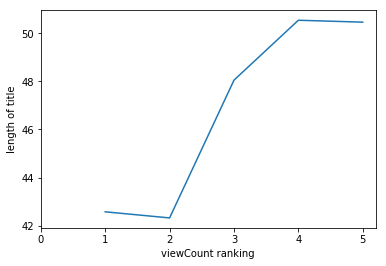

In [126]:
plt.plot(x,y)
plt.xlabel('viewCount ranking')
plt.ylabel('length of title')
plt.xticks([0,1,2,3,4,5])
plt.show()

# Results
조회수가 높을수록 제목 길이가 짧다. 추세를 볼 수 있다.

# Conclusion
제목 길이를 짧게 한다. 영어보다 한글을 쓴다. 왜냐하면 영어를 쓰면 제목 길이가 늘어나기 때문이다.